# Logistic Regression with PyTorch



## Example: Image classification of MNIST handwritten digits

Dataset: [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) (28px by 28px grayscale images of handwritten digits and labels)

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

In [11]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms # transform images into tensors
import torch.nn.functional as F # contains softmax function, cross entropy, etc.
import matplotlib.pyplot as plt

In [ ]:
# Download training dataset and test dataset
# Note: MNIST automatically create a PyTorch Dataset object

dataset = MNIST(root='data/', download=True) # set download=True to save on disk
test_dataset = MNIST(root='data/', train=False) # set train=False for test dataset

# len(dataset) # training dataset has 60000 images
# len(test_dataset) # test dataset has 10000 images

In [20]:
# Download dataset (images + labels) and convert images to tensors
dataset = MNIST(root='data/', train=True,
                transform=transforms.ToTensor())

# Each image is represented by a 1x28x28 tensor (greyscale image has only 1 channel, so the size of the first dimension is 1)
img_tensor, label = dataset[0]
print(img_tensor.shape)

torch.Size([1, 28, 28])


## Preparing the training and validation datasets


1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

  In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

In [21]:
# Split data into training and validation datasets randomly
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])

# Create data loader
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size) # no need to shuffle validation data since it's for evaluation only

## Model

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).



In [22]:
# Define a logistic regression model
# Note: this step is the same as a linear regression model

import torch.nn as nn

input_size = 28*28  # each pixel is an input
num_classes = 10    # 10 target labels (digits 0 to 9)

model = nn.Linear(input_size, num_classes)
# Alternatively, we can define a custom model class as follows
################################################################################

# Create a custom model class by extending the class nn.Module
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__() # call the constructor of the super class, nn.Module
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb): # this method takes a batch of dataset (xb)
        # We need to first flatten the input tensor (xb) first from Nx28x28 to Nx784 (N is the batch size, i.e. no. of images)
        # becasue the model can only take Nx784 input tensor
        xb = xb.reshape(-1, 784) # flatten xb (set first dimension (batch size) to -1 so PyTorch will detect it automatically)
        out = self.linear(xb)
        return out

model = MnistModel()

In [23]:
# Note that the .weight and .bias attributes are now inside the model's .linear attribute, but the `.parameters` method still works
# print(model.linear.weight.shape, model.linear.bias.shape)
# list(model.parameters())

## Training the model

The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

### Loss Function and Evaluation Metric

- **Loss function**: to assess the prediction loss during training phase
- **Evaluation metric**: to evaluate the performance of the model during validation phase

- For evaluation metric, we can use **accuracy**:

  ```accuracy = number of correctly predicted labels / total number of labels```

- Note: Accuracy is easy for human to understand, but can't be used as a loss function because 1) it's not differentiable; 2) it's either correct or incorrect, not taking probability into consideration*

- For loss function, a commonly used function for classification problems is the **cross-entropy**:

  ![cross-entropy](https://i.imgur.com/VDRDl1D.png)
  
  - For each output row, pick the probability for the correct label ($ŷ$)
  - take the logarithm of $ŷ$. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. Vice versa.
  - multiply the result by -1 so the result is positive (the larger the value the higher the "loss")
  - Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data
  - PyTorch has a built-in function for cross entropy:
    ```F.cross_entropy(output, labels)```

### Implementation

- Some parts of the training are specific to problem we're solving (e.g. loss function, metrics etc.) whereas others are generic.
- The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.
- The generic parts will be included in the custom function `fit` as follows:

In [24]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # record epoch-wise results (validation loss and metric) for debugging & visualization

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [25]:
# The problem-specific functions (e.g. loss function, metric) are implemented by
# extending the nn.Module

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        # Calculate average validation loss & metrics
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        # Print results
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# compute accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Choose the hyperparameters (e.g. batch size, learning rate, etc.) that give you a reasonably accurate model within a reasonable amount of training time.

In [12]:
model = MnistModel()
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9484, val_acc: 0.6310
Epoch [1], val_loss: 1.6771, val_acc: 0.7237
Epoch [2], val_loss: 1.4747, val_acc: 0.7582
Epoch [3], val_loss: 1.3217, val_acc: 0.7801
Epoch [4], val_loss: 1.2043, val_acc: 0.7956
Epoch [5], val_loss: 1.1121, val_acc: 0.8064
Epoch [6], val_loss: 1.0382, val_acc: 0.8142
Epoch [7], val_loss: 0.9777, val_acc: 0.8200
Epoch [8], val_loss: 0.9274, val_acc: 0.8243
Epoch [9], val_loss: 0.8849, val_acc: 0.8277


## Testing with individual images

In [15]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0) # because we are only using one image here, we make xb as a batch containing only one image
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


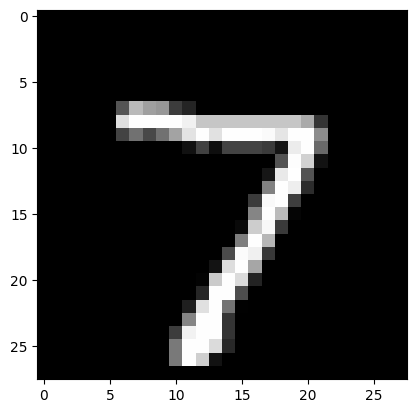

In [17]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Saving and loading the model

In [18]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

To load the model parameters, we can instantiate a new `MnistModel` object, and use the `.load_state_dict` method.

In [19]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))

<All keys matched successfully>

## Use softmax function to convert outputs to probabilities

The model outputs are sets (rows) of scores (each image has a set of 10 scores for 10 labels).


In [13]:
for batch in train_loader:
  images, labels = batch
  break
outputs = model(images)
print(outputs[0]) # print the first output row

tensor([-1.7066,  2.6493,  1.4319,  0.2146, -0.8657, -0.4553, -0.7649, -0.7703,
         1.4952, -0.5174], grad_fn=<SelectBackward0>)




We can convert the outputs to probabilities using softmax:

- raise each output score $y_i$ to $e^{y_i}$, making it positive.
- normalize $e^{y_i}$ by the sum of the corresponding set of raised scores
- the result can be interpreted as a probability

![softmax](https://i.imgur.com/EAh9jLN.png)



In [14]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1) # dim specifies the dimension to which softmax is applied

# Get the max probability in each row and the corresponding label (i.e. the prediction)
max_probs, preds = torch.max(probs, dim=1) # set dim to 1 to get the max value in each row
max_probs, preds

(tensor([0.5279, 0.2450, 0.3406, 0.4394, 0.3002, 0.4449, 0.7698, 0.2968, 0.5912,
         0.4003, 0.2257, 0.2599, 0.5257, 0.8029, 0.2612, 0.2888, 0.2729, 0.7008,
         0.2477, 0.7913, 0.9432, 0.2209, 0.9592, 0.5319, 0.6146, 0.3315, 0.8711,
         0.6532, 0.6159, 0.5654, 0.2273, 0.6751, 0.2801, 0.5639, 0.5081, 0.6516,
         0.2648, 0.2179, 0.4363, 0.3765, 0.5063, 0.6902, 0.3839, 0.3507, 0.3076,
         0.6982, 0.5512, 0.4658, 0.6629, 0.2618, 0.7270, 0.5379, 0.8537, 0.2850,
         0.5156, 0.5273, 0.3530, 0.7766, 0.6358, 0.3417, 0.3918, 0.4233, 0.4339,
         0.2173, 0.6347, 0.3655, 0.8727, 0.9002, 0.2886, 0.2251, 0.2613, 0.6275,
         0.5083, 0.7619, 0.7545, 0.2018, 0.2734, 0.7144, 0.8119, 0.6146, 0.4069,
         0.3731, 0.7856, 0.7367, 0.7800, 0.1959, 0.5482, 0.7851, 0.5913, 0.2812,
         0.4486, 0.3905, 0.7791, 0.5198, 0.2826, 0.4209, 0.5833, 0.4126, 0.4093,
         0.3891, 0.6720, 0.2053, 0.2923, 0.4135, 0.4115, 0.6647, 0.3647, 0.3268,
         0.3723, 0.3376, 0.4